#### Import the facialextractor

In [1]:
from facialextractor import FacialExtractor
from glob import glob
import random
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

2024-07-10 14:02:11.838606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 14:02:11.846112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 14:02:11.856785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 14:02:11.856803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 14:02:11.864166: I tensorflow/core/platform/cpu_feature_gua

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

#### Load random image

In [3]:
puredt_path = '/mnt/disk2/PURE'

In [4]:
# random subject from 1 - 10
ran_sub = random.randint(1, 10)
ran_rec = random.randint(1, 6)

# change the format into two digits
folder_name = str(ran_sub).zfill(2) + '-' + str(ran_rec).zfill(2)
print(f"Folder name: {folder_name}")

# populate the `png` files
png_files = os.listdir(os.path.join(puredt_path, folder_name))
print(f"Total number of files: {len(png_files)}")

Folder name: 02-06
Total number of files: 1943


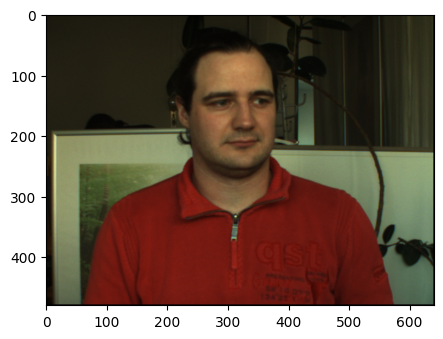

In [5]:
# select a random image
ran_img = random.choice(png_files)
img = cv2.imread(os.path.join(puredt_path, folder_name, ran_img))
img_prv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img_prv); plt.axis('on'); plt.show()

#### Try the `detect_face_bbox`

In [ ]:
facial_extractor = FacialExtractor()
bbox = facial_extractor.detect_face_bbox(image=img)

visualize the bbox

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(cv2.rectangle(img_prv, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)); plt.axis('on'); plt.show()
# calculate the bbox width and height
bbox_width = bbox[2] - bbox[0]
bbox_height = bbox[3] - bbox[1]
print(f"Bounding box width: {bbox_width} | height: {bbox_height}")


#### Try to mask the face

In [ ]:
cropped_face = facial_extractor.crop_img(image=img, bbox=bbox)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face); plt.axis('on'); plt.show()
print(f"Cropped face shape: {cropped_face.shape}")

#### Try to detect the forehead

In [ ]:
interest_point = facial_extractor.detect_lm(image=cropped_face)
cropped_face_prev = cropped_face.copy()
print(f"Interest point: {interest_point}")

In [ ]:
# visualize the interest point
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face_prev)
for i, point in enumerate(interest_point):
    plt.scatter(point[0], point[1], c='r', s=10)

#### Segment Face

In [ ]:
masks, scores, logits = facial_extractor.segment_face(
    image=cropped_face,
    interest_point=interest_point,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(cropped_face)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

#### Extract Face Skin

In [ ]:
face_skin_img = facial_extractor.extract_face_skin(
    image=cropped_face,
    mask=masks,
)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(face_skin_img); plt.axis('on'); plt.show()

### Try the tracker

In [ ]:
img_path = os.path.join(puredt_path, folder_name)
print(f"Image path: {img_path}")

In [ ]:
facial_extractor = FacialExtractor(expandbbox=2.0)
bboxes = facial_extractor.track_img_frames(path=img_path)

In [ ]:
img_files = sorted(glob(os.path.join(img_path, "*.*")))
img_files = [f for f in img_files if f.endswith(("jpg", "jpeg", "png"))]
print(f"Total number of files: {len(img_files)} | Total number of bounding boxes: {len(bboxes)}")

In [ ]:
facial_extractor.preview_tracking(
    image_paths = img_files,
    bboxes = bboxes,
    num_frames=20,
)

### Final Pipeline: `process_img_frames`

In [6]:
facial_extractor = FacialExtractor(expandbbox=2.0)
img_path = os.path.join(puredt_path, folder_name)
all_face_skins = facial_extractor.process_img_frames(img_path)

I0000 00:00:1720591334.736441 1318967 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720591334.839623 1319150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.23.08), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1720591334.858390 1319141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720591334.861822 1319135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing frame 0 from 1943 frames...
Processing frame 20 from 1943 frames...
Processing frame 40 from 1943 frames...
Processing frame 60 from 1943 frames...
Processing frame 80 from 1943 frames...
Processing frame 100 from 1943 frames...
Processing frame 120 from 1943 frames...
Processing frame 140 from 1943 frames...
Processing frame 160 from 1943 frames...
Processing frame 180 from 1943 frames...
Processing frame 200 from 1943 frames...
Processing frame 220 from 1943 frames...
Processing frame 240 from 1943 frames...
Processing frame 260 from 1943 frames...
Processing frame 280 from 1943 frames...
Processing frame 300 from 1943 frames...
Processing frame 320 from 1943 frames...
Processing frame 340 from 1943 frames...
Processing frame 360 from 1943 frames...
Processing frame 380 from 1943 frames...
Processing frame 400 from 1943 frames...
Processing frame 420 from 1943 frames...
Processing frame 440 from 1943 frames...
Processing frame 460 from 1943 frames...
Processing frame 480 f

In [7]:
# save numpy array as file
np.save(os.path.join('./', 'face_skins.npy'), all_face_skins)

In [8]:
print(f"Shape of all face skins: {all_face_skins.shape} | Type: {type(all_face_skins)}")

Shape of all face skins: (1943, 224, 224, 3) | Type: <class 'numpy.ndarray'>


### Preview as Image

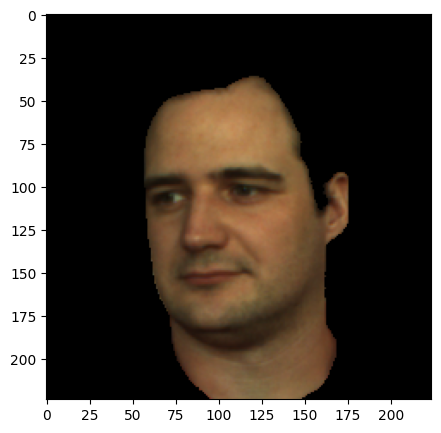

In [15]:
sample_img = all_face_skins[255]
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(sample_img); plt.axis('on'); plt.show()

### Preview as Video

In [20]:
def create_video_from_numpy(frames, output_path, fps=30):
    """
    Create an MP4 video from a numpy array of frames.

    Args:
        frames (numpy.ndarray): 4D array of frames (num_frames x height x width x channels)
        output_path (str): Path where the output video will be saved
        fps (int): Frames per second for the output video

    Returns:
        None
    """
    # Get the dimensions of the frames
    num_frames, height, width, channels = frames.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i in range(num_frames):
        out.write(frames[i])

    # Release the VideoWriter
    out.release()

    print(f"Video saved to {output_path}")

In [21]:
output_path = "face_skins_video.mp4"
fps = 30  # You can adjust this value as needed

create_video_from_numpy(all_face_skins, output_path, fps)

Video saved to face_skins_video.mp4
